In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


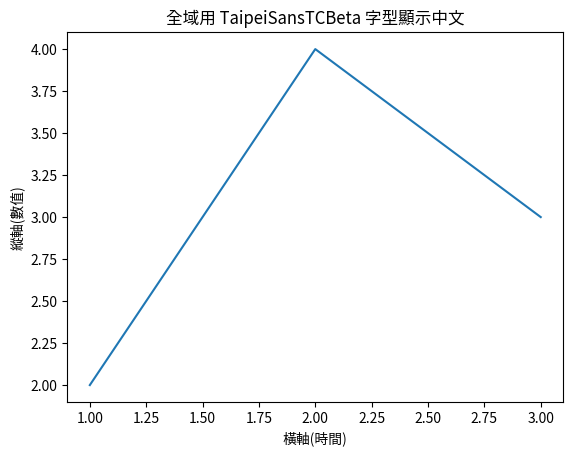

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 把你的字型檔路徑放到變數裡
font_path = "./font/TaipeiSansTCBeta-Regular.ttf"

# 2. 將字型加到 Matplotlib 的字型清單裡
fm.fontManager.addfont(font_path)

# 3. 取出這個字型的「內部名稱」（FontProperties.get_name() 會拿到 ttf 裡面定義的字型名稱）
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()   # 例如會得到 "Taipei Sans TC Beta" 或類似的字型名稱

# 4. 把全域 rcParams 改掉，讓 sans-serif 第一順位就是這個名稱
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_name]  # 以剛剛抓到的名稱為準

# 5. 讓負號正常顯示
plt.rcParams['axes.unicode_minus'] = False

# 測試一下
x = [1, 2, 3]
y = [2, 4, 3]
plt.plot(x, y)
plt.title("全域用 TaipeiSansTCBeta 字型顯示中文")
plt.xlabel("橫軸(時間)")
plt.ylabel("縱軸(數值)")
plt.show()


## 2. 資料前處理

In [4]:
udn = pd.read_csv("raw_data/student_2_5_8.csv")  # 匯資料
udn.head(3)

,artTitle,artContent
0,郭子乾趕高鐵巧遇王世堅 網譏「想看韓院長表示....」,郭子乾（左）和王世堅昨在高鐵站巧遇，開心拍下同框合影。（翻攝自郭子乾臉書）\n〔記者林南谷／...
1,國民黨智庫籲新政府解除不合時宜兩岸禁令 恢復正常往來,2024/05/14 15:49\n\n\n 國民黨智庫表示，國民黨將在智庫國安組召集人陳永...
2,漲電價要立法院同意！藍白再聯手表決通過「電業法」逕付二讀,2024/05/03 11:54\n\n\n 立法院議場上演藍綠表決攻防，國民黨團高喊凍漲電...


,artTitle,content
0,郭子乾趕高鐵巧遇王世堅網譏想看韓院長表示,郭子乾左和王世堅昨在高鐵站巧遇開心拍下同框合影翻攝自郭子乾臉書記者林南谷台北報導藝人郭子乾月...
1,國民黨智庫籲新政府解除不合時宜兩岸禁令恢復正常往來,國民黨智庫表示國民黨將在智庫國安組召集人陳永康見圖的帶領下於立法院下會期推動國家安全戰略法立...
2,漲電價要立法院同意藍白再聯手表決通過電業法逕付二讀,立法院議場上演藍綠表決攻防國民黨團高喊凍漲電價苦民所苦記者田裕華攝記者林欣漢陳政宇李文馨台北...
3,徐巧芯丈夫被控過去是挺朱網軍朱立倫外界不應牽拖,國民黨智庫日召開新政府新期待別讓人民受傷害記者會國民黨主席朱立倫出席致詞並於會後受訪記者塗建...
4,姓名條例修正草案三讀通過原住民族可於身分證單列族名,立法院長韓國瑜敲下議事槌三讀通過姓名條例部分條文修正草案記者劉信德攝記者林欣漢台北報導立法院...


In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /home/vince-ylf/NSYSU/113-2/SMA/week09/dict/dict.txt.big ...
2025-06-08 11:21:00,470 : DEBUG : Building prefix dict from /home/vince-ylf/NSYSU/113-2/SMA/week09/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u02a3275727c6ca2189ef7a250cb187d0.cache
2025-06-08 11:21:00,474 : DEBUG : Loading model from cache /tmp/jieba.u02a3275727c6ca2189ef7a250cb187d0.cache
Loading model cost 0.510 seconds.
2025-06-08 11:21:00,983 : DEBUG : Loading model cost 0.510 seconds.
Prefix dict has been built successfully.
2025-06-08 11:21:00,983 : DEBUG : Prefix dict has been built successfully.


,artTitle,content,words
0,郭子乾趕高鐵巧遇王世堅網譏想看韓院長表示,郭子乾左和王世堅昨在高鐵站巧遇開心拍下同框合影翻攝自郭子乾臉書記者林南谷台北報導藝人郭子乾月...,"[郭子, 王世堅, 昨在, 高鐵, 巧遇, 開心, 下同, 合影, 翻攝, 郭子, 乾臉, ..."
1,國民黨智庫籲新政府解除不合時宜兩岸禁令恢復正常往來,國民黨智庫表示國民黨將在智庫國安組召集人陳永康見圖的帶領下於立法院下會期推動國家安全戰略法立...,"[國民黨, 智庫, 表示, 國民黨, 將在, 智庫, 國安, 召集人, 永康, 見圖, 帶領..."
2,漲電價要立法院同意藍白再聯手表決通過電業法逕付二讀,立法院議場上演藍綠表決攻防國民黨團高喊凍漲電價苦民所苦記者田裕華攝記者林欣漢陳政宇李文馨台北...,"[立法院, 議場, 上演, 藍綠, 表決, 攻防, 國民黨, 高喊, 凍漲, 電價, 苦民所..."
3,徐巧芯丈夫被控過去是挺朱網軍朱立倫外界不應牽拖,國民黨智庫日召開新政府新期待別讓人民受傷害記者會國民黨主席朱立倫出席致詞並於會後受訪記者塗建...,"[國民黨, 智庫, 召開, 新政府, 期待, 受傷害, 記者會, 國民黨, 主席, 朱立倫,..."
4,姓名條例修正草案三讀通過原住民族可於身分證單列族名,立法院長韓國瑜敲下議事槌三讀通過姓名條例部分條文修正草案記者劉信德攝記者林欣漢台北報導立法院...,"[立法, 院長, 韓國, 敲下, 議事, 三讀通過, 姓名, 條例, 部分, 條文, 修正,..."


## LDA 主題模型

將斷詞後的`doc['words']`轉換成list

In [8]:
docs = udn['words'].to_list()
docs[0]

['郭子',
 '王世堅',
 '昨在',
 '高鐵',
 '巧遇',
 '開心',
 '下同',
 '合影',
 '翻攝',
 '郭子',
 '乾臉',
 '書記',
 '林南谷',
 '台北',
 '報導',
 '藝人',
 '郭子',
 '化身',
 '立法',
 '院長',
 '韓國',
 '前往',
 '立院',
 '拍片',
 '期間',
 '還跑',
 '民進黨',
 '立委',
 '王世堅',
 '辦公室',
 '拜會',
 '事後',
 '王世堅',
 '受訪',
 '表示',
 '當時',
 '嚇到並',
 '稱讚',
 '郭子',
 '模仿',
 '超像',
 '只能',
 '說分',
 '以上',
 '沒想到',
 '郭子',
 '昨在',
 '高鐵',
 '趕路',
 '行程',
 '巧遇',
 '王世堅',
 '兩人',
 '下同',
 '合影',
 '事後',
 '郭子',
 '臉書',
 '照說',
 '節目',
 '模仿',
 '合照',
 '機會',
 '用哥',
 '本尊',
 '合照',
 '直呼',
 '真是',
 '太巧',
 '今年',
 '郭子',
 '前往',
 '立院',
 '拍片',
 '王世堅',
 '模仿',
 '韓國',
 '活靈活現',
 '仔細',
 '研究',
 '韓國',
 '背景',
 '說完',
 '全不',
 '知道',
 '郭子',
 '乾會',
 '立法院',
 '當時',
 '郭子',
 '乾進',
 '來時',
 '還以',
 '真的',
 '韓國',
 '爆笑',
 '郭子',
 '昨曬出',
 '王世堅',
 '同框',
 '意外',
 '釣出',
 '粉絲',
 '網友',
 '留言',
 '很想',
 '看韓',
 '院長',
 '表示']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [9]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-06-08 11:21:02,989 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-08 11:21:03,049 : INFO : built Dictionary<21873 unique tokens: ['下同', '乾會', '乾臉', '乾進', '事後']...> from 749 documents (total 149247 corpus positions)
2025-06-08 11:21:03,049 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<21873 unique tokens: ['下同', '乾會', '乾臉', '乾進', '事後']...> from 749 documents (total 149247 corpus positions)", 'datetime': '2025-06-08T11:21:03.049896', 'gensim': '4.3.3', 'python': '3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]', 'platform': 'Linux-6.8.0-60-generic-x86_64-with-glibc2.35', 'event': 'created'}
2025-06-08 11:21:03,055 : INFO : discarding 18002 tokens: [('下同', 1), ('乾會', 1), ('乾臉', 1), ('乾進', 1), ('仔細', 3), ('來時', 3), ('全不', 1), ('化身', 4), ('同框', 1), ('嚇到並', 1)]...
2025-06-08 11:21:03,056 : INFO : keeping 3871 tokens which were in no less than 5 and no more than 741 (=99.0%) documents
2025-06-08 11:21:03,058 : INFO : resulting dictionary: Dictio

Dictionary<3871 unique tokens: ['事後', '今年', '以上', '兩人', '前往']...>


- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [10]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

事後: 0
今年: 1
以上: 2
兩人: 3
前往: 4
受訪: 5
只能: 6
台北: 7
合影: 8
合照: 9
報導: 10
意外: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [11]:
pprint(" ".join(udn['words'].iloc[600]))

('台股 低點 以來 已強 彈逾點 資料 母公司 微軟 重量級 科技 大廠 財報 亮眼 美國 科技股 上週五 反彈 激勵 昨台 積電 率領 多頭 再攻 '
 '金融資產 營建 貨櫃 航運 生技 族群 同步 助攻 加權指數 終場 大漲點 順利 攻克 月線 收在點 成交量 億元 台股 低點 以來 已強 彈逾點 因台 '
 '積電法 全球 半導體 成長 中東 戰火 利空 打擊 美國 增溫 引發 降息 延後 疑慮 台股 日前 一度 暴跌 萬點大關 最低 來到 點隨著 中東 戰火 '
 '趨緩 美股 回穩 台股 展開 強勢 反彈 法人 合計 買超 台股 億元 外資 買超 億元 投信 買超 億元 自營商 買超 億元 外資 指期 淨空 增加 '
 '累積 外資 指期 淨空 單約 萬口 保德信 新世紀 基金 經理人 廖炳 指出 美股 部分 龍頭股 財報 報喜 輝達 博通 美光 指標股 領頭 反彈 激勵 '
 '這波台 股急 尚未 碰到 季線 旋即 反彈 反映 多方 強且 上揚 本次 反彈 籌碼 較輕 未來 下檔 支撐 看季線 位置 記者 卓怡君 一手 掌握 '
 '經濟 脈動')


第600篇文章的前十個詞彙的語料庫ID和頻率

In [12]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(71, 1),
 (145, 1),
 (149, 1),
 (199, 1),
 (209, 1),
 (231, 1),
 (238, 1),
 (285, 1),
 (343, 1),
 (354, 1)]

In [13]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

**訓練 LDA topic model**

In [14]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2025, # 亂數
)

2025-06-08 11:21:03,300 : INFO : using symmetric alpha at 0.25
2025-06-08 11:21:03,300 : INFO : using symmetric eta at 0.25
2025-06-08 11:21:03,301 : INFO : using serial LDA version on this node
2025-06-08 11:21:03,302 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 749 documents, updating model once every 749 documents, evaluating perplexity every 749 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-08 11:21:03,302 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-08 11:21:03,520 : INFO : -8.833 per-word bound, 456.1 perplexity estimate based on a held-out corpus of 749 documents with 112327 words
2025-06-08 11:21:03,520 : INFO : PROGRESS: pass 0, at document #749/749
2025-06-08 11:21:03,664 : INFO : topic #0 (0.250): 0.010*"地震" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"表示" + 0.007*"報導" + 0.006*"立委" + 0.006*"國民黨" + 0.006*"提供" +

**查看 LDA 的4個主題，每個主題中最重要的10個詞彙** <br>

In [15]:
ldamodel.print_topics()

2025-06-08 11:21:03,669 : INFO : topic #0 (0.250): 0.010*"地震" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"表示" + 0.007*"報導" + 0.006*"立委" + 0.006*"國民黨" + 0.006*"提供" + 0.005*"民進黨" + 0.005*"台灣"
2025-06-08 11:21:03,669 : INFO : topic #1 (0.250): 0.010*"表示" + 0.008*"地震" + 0.008*"記者" + 0.007*"報導" + 0.007*"花蓮" + 0.007*"立法院" + 0.005*"立委" + 0.005*"國民黨" + 0.005*"台灣" + 0.004*"民進黨"
2025-06-08 11:21:03,669 : INFO : topic #2 (0.250): 0.010*"立委" + 0.008*"表示" + 0.007*"國民黨" + 0.007*"民進黨" + 0.006*"報導" + 0.006*"立法院" + 0.006*"記者" + 0.005*"台灣" + 0.004*"國會" + 0.004*"民眾"
2025-06-08 11:21:03,670 : INFO : topic #3 (0.250): 0.011*"台灣" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"民進黨" + 0.007*"表示" + 0.007*"報導" + 0.006*"地震" + 0.005*"國民黨" + 0.005*"立法院" + 0.004*"立委"


[(0,
  '0.010*"地震" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"表示" + 0.007*"報導" + 0.006*"立委" + 0.006*"國民黨" + 0.006*"提供" + 0.005*"民進黨" + 0.005*"台灣"'),
 (1,
  '0.010*"表示" + 0.008*"地震" + 0.008*"記者" + 0.007*"報導" + 0.007*"花蓮" + 0.007*"立法院" + 0.005*"立委" + 0.005*"國民黨" + 0.005*"台灣" + 0.004*"民進黨"'),
 (2,
  '0.010*"立委" + 0.008*"表示" + 0.007*"國民黨" + 0.007*"民進黨" + 0.006*"報導" + 0.006*"立法院" + 0.006*"記者" + 0.005*"台灣" + 0.004*"國會" + 0.004*"民眾"'),
 (3,
  '0.011*"台灣" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"民進黨" + 0.007*"表示" + 0.007*"報導" + 0.006*"地震" + 0.005*"國民黨" + 0.005*"立法院" + 0.004*"立委"')]

## 視覺化呈現 LDAvis 

In [16]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 2025,
    passes = 5 # 訓練次數
    )

2025-06-08 11:21:03,723 : INFO : using symmetric alpha at 0.25
2025-06-08 11:21:03,724 : INFO : using symmetric eta at 0.25
2025-06-08 11:21:03,726 : INFO : using serial LDA version on this node
2025-06-08 11:21:03,730 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 749 documents, updating model once every 749 documents, evaluating perplexity every 749 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-08 11:21:03,730 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-08 11:21:03,955 : INFO : -8.833 per-word bound, 456.1 perplexity estimate based on a held-out corpus of 749 documents with 112327 words
2025-06-08 11:21:03,956 : INFO : PROGRESS: pass 0, at document #749/749
2025-06-08 11:21:04,098 : INFO : topic #0 (0.250): 0.010*"地震" + 0.008*"花蓮" + 0.008*"記者" + 0.007*"表示" + 0.007*"報導" + 0.006*"立委" + 0.006*"國民黨" + 0.006*"提供" + 

In [21]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.187621 -0.001382       1        1  39.313249
0     -0.065730 -0.130069       2        1  26.043301
3     -0.064988  0.100202       3        1  25.338633
1     -0.056904  0.031249       4        1   9.304816, topic_info=     Term        Freq       Total Category  logprob  loglift
1041   地震  765.000000  765.000000  Default  30.0000  30.0000
213    花蓮  732.000000  732.000000  Default  29.0000  29.0000
2900   晶片  325.000000  325.000000  Default  28.0000  28.0000
2907   輝達  281.000000  281.000000  Default  27.0000  27.0000
3706   股價  239.000000  239.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
604    目前   41.883261  311.002598   Topic4  -5.5196   0.3697
1150   公司   36.083466  189.306060   Topic4  -5.6687   0.7171
60     台灣   40.901259  708.079047   Topic4  -5.5434  -0.4768
498    綜合   33.682415  297.468209   Topic4  -5.7376   0.1963
27    立法院   34.584030  618.098935   Topic4  -5.7111  -0.5086

[313 rows x 6 columns], token_table=      Topic      Freq Term
term                      
386       1  0.018167   一手
386       2  0.127172   一手
386       3  0.678250   一手
386       4  0.175618   一手
3340      1  0.933665   七六
...     ...       ...  ...
3725      4  0.926371   點或
241       1  0.746813   黨團
241       2  0.073629   黨團
241       3  0.152518   黨團
241       4  0.026296   黨團

[878 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [20]:
pyLDAvis.save_html(p, "lda_zh.html")